In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! pip install keras-tuner

In [ ]:
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from sklearn.preprocessing import MinMaxScaler
import matplotlib.cbook as cbook
import tensorflow as tf
import kerastuner as kt
from tensorflow.keras.losses import MeanAbsoluteError
import keras
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [ ]:
pd.options.display.float_format = '{:.3f}'.format

np.set_printoptions(suppress=True)

In [ ]:
path = r'/content/gdrive/MyDrive/bus' # use your path
all_files = glob.glob(path + "/*.csv")
all_files.sort()

In [ ]:
li_train = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_train.append(df)
frame = pd.concat(li_train, axis=0, ignore_index=True)
frame.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
0,7,7,10,7,7,0,0,310,3,3,...,7.000,7.000,10.000,10.000,0,0,14,7,7,1769
1,7,7,7,10,7,0,0,0,310,3,...,8.000,7.000,7.000,10.000,0,0,0,14,7,2272
2,7,7,7,7,10,0,0,0,0,310,...,8.000,8.000,7.000,7.000,0,0,0,0,14,2549
3,9,7,7,7,7,1757,0,0,0,0,...,10.000,8.000,8.000,7.000,68,0,0,0,0,2674
4,9,9,7,7,7,4216,1757,0,0,0,...,10.000,10.000,8.000,8.000,151,68,0,0,0,2393


In [ ]:
frame.shape

(10639, 46)

# Dealing with Nan Values

In [ ]:
frame.replace('-', np.NaN, inplace = True)
frame.isna().sum().sum()

100772

In [ ]:
imputer = IterativeImputer(imputation_order='ascending',max_iter=10,random_state=42,n_nearest_features=None)
imputed_dataset = imputer.fit_transform(frame)
frame = pd.DataFrame(imputed_dataset,columns = frame.columns)
frame.isna().sum().sum()

0

In [ ]:
frame.describe()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
count,10639.000,10639.000,10639.000,10639.000,10639.000,10639.000,10639.000,10639.000,10639.000,10639.000,...,10639.000,10639.000,10639.000,10639.000,10639.000,10639.000,10639.000,10639.000,10639.000,10639.000
mean,8.232,8.135,8.112,8.099,8.125,9984.640,9997.880,10013.592,10029.786,10047.591,...,5.161,5.043,5.007,5.019,183.025,183.238,183.468,183.705,183.951,9953.148
std,2.435,2.433,2.434,2.434,2.433,11372.752,11397.918,11422.153,11448.840,11484.282,...,6.734,6.708,6.700,6.703,193.709,194.036,194.337,194.660,195.046,10744.687
min,1.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,...,-15.000,-15.000,-15.000,-15.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,7.000,7.000,7.000,7.000,7.000,2124.000,2124.000,2124.000,2124.000,2124.000,...,1.000,1.000,1.000,1.000,48.000,48.000,48.000,48.000,48.000,2357.000
50%,8.301,8.000,8.000,7.992,8.000,5972.000,5972.000,5972.000,5983.000,5994.000,...,6.590,6.132,6.010,6.000,122.000,122.000,122.000,123.000,123.000,6347.000
75%,9.000,9.000,9.000,9.000,9.000,13946.000,13951.500,13980.000,14002.000,14018.500,...,7.000,7.000,7.000,7.000,256.000,256.000,256.000,256.000,257.000,13998.500
max,15.000,15.000,15.000,15.000,15.000,87872.000,87872.000,87872.000,87872.000,87872.000,...,32.000,32.000,32.000,32.000,2179.000,2179.000,2179.000,2179.000,2179.000,75533.000


In [ ]:
frame.isna().sum().sum()

0

In [ ]:
# LOW - below 1000
# MEDIUM - between 1000 and 4000
# HIGH - greater than 4000

In [ ]:
frame_low = frame[frame['DL_bitrate']<=1000]
frame_medium = frame[(frame['DL_bitrate']>1000) & (frame['DL_bitrate']<=4000)]
frame_high = frame[frame['DL_bitrate']>4000]

In [ ]:
frame_low.shape

(1337, 46)

In [ ]:
frame_medium.shape

(2660, 46)

In [ ]:
frame_high.shape

(6642, 46)

In [ ]:
col_names_scaled =['CQI-0', 'CQI-1', 'CQI-2', 'CQI-3', 'CQI-4', 'DL_bitrate-0',
       'DL_bitrate-1', 'DL_bitrate-2', 'DL_bitrate-3', 'DL_bitrate-4', 'SNR-0', 'SNR-1', 'SNR-2', 'SNR-3', 'SNR-4', 'DL_bitrate']

# Random Split

## Low Throughput

In [ ]:
frame_low_train = frame_low.sample(frac = 0.7, random_state=0)
frame_low_test = frame_low.drop(frame_low_train.index)

In [ ]:
frame_low_train.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
6798,6.000,6.000,6.000,7.000,7.000,1588.000,794.000,961.000,503.000,749.000,...,1.000,2.000,2.000,2.000,29.000,15.000,21.000,10.000,17.000,632.000
2648,9.000,8.000,6.000,4.000,6.000,0.000,0.000,1.000,2.000,1.000,...,3.000,3.000,1.000,-2.000,0.000,0.000,0.000,0.000,0.000,4.000
2415,10.000,10.000,10.000,10.000,10.000,0.000,0.000,0.000,0.000,0.000,...,9.000,9.000,9.000,9.000,0.000,0.000,0.000,0.000,0.000,0.000
2532,8.000,8.000,8.000,8.000,8.000,415.000,1157.000,1115.000,839.000,669.000,...,1.000,1.000,1.000,1.000,84.000,208.000,126.000,64.000,120.000,792.000
1151,8.257,7.908,7.879,7.835,7.943,469.000,190.000,0.000,402.000,726.000,...,6.676,6.191,6.131,6.053,21.000,8.000,0.000,11.000,16.000,408.000


In [ ]:
frame_low_test.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
20,9.000,9.000,9.000,9.000,9.000,313.000,1107.000,156.000,2169.000,1543.000,...,9.000,9.000,10.000,10.000,12.000,30.000,5.000,69.000,30.000,471.000
23,8.000,6.000,7.000,9.000,9.000,1185.000,705.000,100.000,313.000,1107.000,...,2.000,7.000,7.000,9.000,26.000,28.000,5.000,12.000,30.000,424.000
27,6.000,6.000,7.000,7.000,8.000,749.000,995.000,234.000,134.000,1185.000,...,0.000,2.000,3.000,2.000,22.000,38.000,10.000,4.000,26.000,333.000
29,6.000,6.000,6.000,6.000,7.000,950.000,11.000,749.000,995.000,234.000,...,1.000,0.000,0.000,2.000,24.000,0.000,22.000,38.000,10.000,348.000
39,7.000,7.000,7.000,7.000,7.000,123.000,436.000,659.000,436.000,693.000,...,0.000,-1.000,-1.000,0.000,5.000,9.000,14.000,8.000,13.000,283.000


In [ ]:
print(frame_low_train.shape)
print(frame_low_test.shape)

(936, 46)
(401, 46)


### With Scaling

#### MinMax Scaler

In [ ]:
df = frame_low_train[col_names_scaled]
min_max_scaler = MinMaxScaler()
# transform data
df_min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))

In [ ]:
X_train_min_max_scaler, X_valid_min_max_scaler, Y_train_min_max_scaler, Y_valid_min_max_scaler = train_test_split(df_min_max_scaled.iloc[:,:-1], df_min_max_scaled.iloc[:,-1:], test_size=0.3, random_state=0)
print('Train set shape', X_train_min_max_scaler.shape)
print('Validation set shape', X_valid_min_max_scaler.shape)
X_train_min_max_scaler.head()

Train set shape (655, 15)
Validation set shape (281, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
116,0.417,0.417,0.667,0.667,0.667,0.062,0.039,0.049,0.058,0.054,0.462,0.462,0.542,0.500,0.458
76,0.603,0.579,0.575,0.570,0.579,0.035,0.046,0.034,0.022,0.020,0.808,0.761,0.800,0.735,0.711
48,0.083,0.083,0.083,0.083,0.083,0.000,0.000,0.000,0.000,0.000,0.538,0.538,0.750,0.692,0.625
311,0.603,0.578,0.577,0.570,0.579,0.000,0.000,0.000,0.000,0.000,0.809,0.760,0.801,0.731,0.707
263,0.606,0.578,0.576,0.569,0.578,0.000,0.000,0.000,0.000,0.000,0.811,0.759,0.800,0.735,0.710


In [ ]:
X_train_min_max_series = X_train_min_max_scaler.values.reshape((X_train_min_max_scaler.shape[0], X_train_min_max_scaler.shape[1], 1))
X_valid_min_max_series = X_valid_min_max_scaler.values.reshape((X_valid_min_max_scaler.shape[0], X_valid_min_max_scaler.shape[1], 1))
print('Train set shape', X_train_min_max_series.shape)
print('Validation set shape', X_valid_min_max_series.shape)

Train set shape (655, 15, 1)
Validation set shape (281, 15, 1)


### Hyper Parameter Tuning using Keras Auto Tuner

In [ ]:
mae = MeanAbsoluteError()
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(X_train_min_max_series.shape[1], X_train_min_max_series.shape[2])))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512

  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  model.add(Dense(units=hp_units1, activation='relu'))
  model.add(Dropout(rate=hp.Float('dropout_1',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(tf.keras.layers.Dense(units=hp_units2, activation='relu'))
  model.add(Dropout(rate=hp.Float('dropout_2',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(tf.keras.layers.Dense(units=hp_units3, activation='relu'))

  model.add(Dropout(rate=hp.Float('dropout_3',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(Dense(1, kernel_initializer='normal', activation='linear'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),loss=mae,metrics=[mae])

  return model


In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_mean_absolute_error',
                     max_epochs=100,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')


In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, 
        verbose=1, mode='auto', restore_best_weights=True)

In [ ]:
tuner.search(X_train_min_max_series, Y_train_min_max_scaler, validation_data=(X_valid_min_max_series, Y_valid_min_max_scaler), epochs=100, callbacks=[monitor])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 254 Complete [00h 00m 09s]
val_mean_absolute_error: 0.1320672333240509

Best val_mean_absolute_error So Far: 0.12914343178272247
Total elapsed time: 00h 08m 12s


In [ ]:
for h_param in [f"units{i}" for i in range(1,4)] + ['learning_rate']:
  print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))

units1 512
units2 320
units3 448
learning_rate 0.001


In [ ]:
best_model = tuner.get_best_models()[0]
best_model.build(X_train_min_max_series.shape)
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 15)                0         
                                                                 
 dense (Dense)               (None, 512)               8192      
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 320)               164160    
                                                                 
 dropout_1 (Dropout)         (None, 320)               0         
                                                                 
 dense_2 (Dense)             (None, 448)               143808    
                                                                 
 dropout_2 (Dropout)         (None, 448)               0

In [ ]:
from keras.models import load_model

best_model.save('best_model.h5')  # creates a HDF5 file 'my_model.h5'
#model = load_model('my_model.h5')

In [ ]:
kt_train_pred_min_max_scaled = best_model.predict(X_train_min_max_scaler)
kt_valid_pred_min_max_scaled = best_model.predict(X_valid_min_max_scaler)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_min_max_scaler, kt_train_pred_min_max_scaled)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_min_max_scaler, kt_valid_pred_min_max_scaled)))

9/9 [==============================] - 0s 2ms/step
Train rmse: 0.15751150606385506
Validation rmse: 0.2085675884124663


In [ ]:
df = frame_low_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.727,0.889,0.800,0.583,0.615,0.032,0.132,0.013,0.188,0.134,0.750,0.833,0.826,0.885,0.796
1,0.636,0.556,0.600,0.583,0.615,0.122,0.084,0.008,0.027,0.096,0.542,0.542,0.739,0.769,0.761
2,0.455,0.556,0.600,0.417,0.538,0.077,0.119,0.019,0.012,0.103,0.458,0.458,0.522,0.615,0.519
3,0.455,0.556,0.500,0.333,0.462,0.098,0.001,0.062,0.086,0.020,0.500,0.500,0.435,0.500,0.519
4,0.545,0.667,0.600,0.417,0.462,0.013,0.052,0.054,0.038,0.060,0.458,0.458,0.391,0.462,0.450


In [ ]:
Y_test = frame_low_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = best_model.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

13/13 [==============================] - 0s 1ms/step


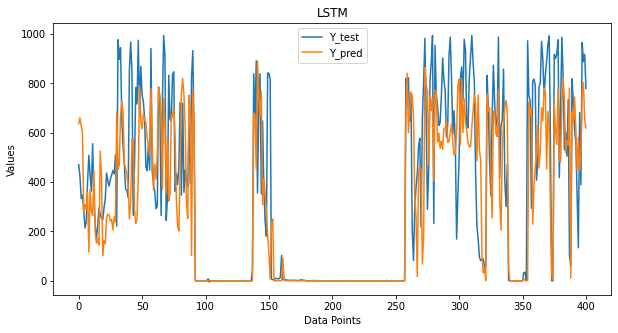

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(10,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

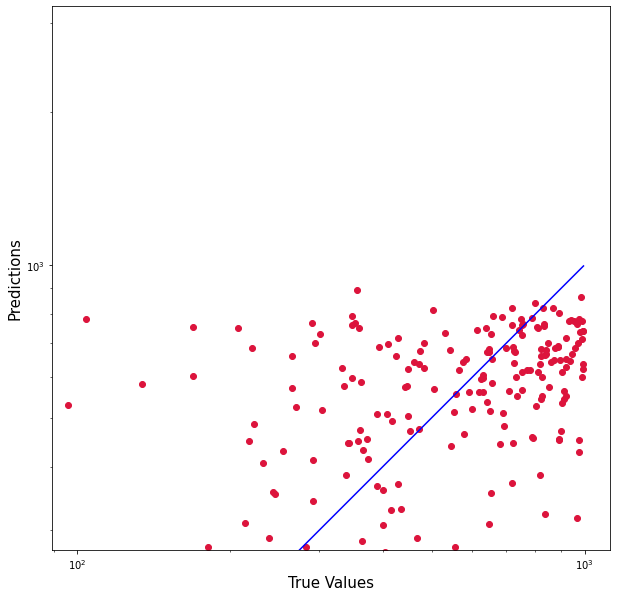

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(Y_test['DL_bitrate'], Y_pred[15], c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(Y_pred[15]), max(Y_test['DL_bitrate']))
p2 = min(min(Y_pred[15]), min(Y_test['DL_bitrate']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

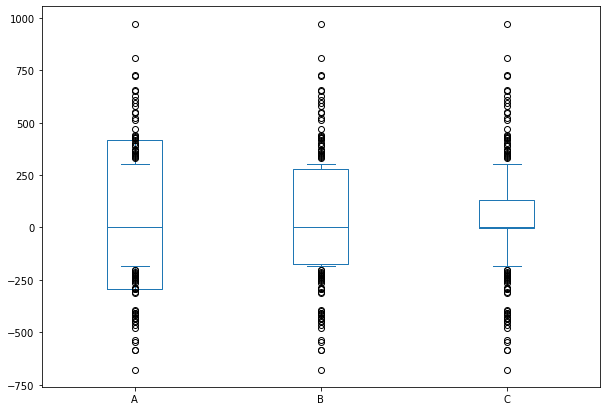

In [ ]:
import matplotlib.cbook as cbook
a=Y_test['DL_bitrate'].subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
# calculate MAE
error = mae(Y_test, Y_pred)

# display
print("Mean absolute error : " + str(error))
print(f"Decimal Representation: {error:.20f}")

Mean absolute error : tf.Tensor(127.85608984852016, shape=(), dtype=float64)
Decimal Representation: 127.85608984852015623801


In [ ]:
# Mean Absolute Percentage Error
error = mean_absolute_percentage_error(Y_test, Y_pred)
print(error)

print(f" {error:.5f}")

718391094239007.9
 718391094239007.87500


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

0.4512609573733438

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

0.48982116791137803

# Random Split

## Medium Throughput

In [ ]:
frame_medium_train = frame_medium.sample(frac = 0.7, random_state=0)
frame_medium_test = frame_medium.drop(frame_medium_train.index)

In [ ]:
frame_medium_train.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
1040,2.000,4.000,5.000,6.000,7.000,2728.000,14829.000,7303.000,6811.000,6520.000,...,1.000,4.000,4.000,0.000,51.000,369.000,139.000,124.000,120.000,2708.000
3594,8.464,8.110,8.006,7.970,8.059,1599.000,1767.000,1319.000,1543.000,1297.000,...,6.602,6.237,6.194,6.268,29.000,32.000,31.000,36.000,28.000,1314.000
7343,7.000,7.000,7.000,7.000,7.000,961.000,1084.000,1163.000,1621.000,1856.000,...,7.000,7.000,7.000,7.000,54.000,62.000,23.000,30.000,35.000,1388.000
2369,7.000,7.000,8.000,8.000,8.000,11327.000,7336.000,13185.000,8566.000,4285.000,...,5.000,5.000,6.000,6.000,308.000,137.000,248.000,188.000,162.000,1496.000
4507,8.509,8.158,8.048,8.022,8.094,1644.000,1543.000,1252.000,1062.000,939.000,...,6.732,6.293,6.111,6.049,34.000,46.000,24.000,19.000,17.000,2824.000


In [ ]:
frame_medium_test.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
0,7.000,7.000,10.000,7.000,7.000,0.000,0.000,310.000,3.000,3.000,...,7.000,7.000,10.000,10.000,0.000,0.000,14.000,7.000,7.000,1769.000
3,9.000,7.000,7.000,7.000,7.000,1757.000,0.000,0.000,0.000,0.000,...,10.000,8.000,8.000,7.000,68.000,0.000,0.000,0.000,0.000,2674.000
7,7.000,8.000,9.000,9.000,9.000,1386.000,2516.000,2874.000,4216.000,1757.000,...,10.000,10.000,10.000,10.000,26.000,47.000,53.000,151.000,68.000,2357.000
12,7.000,7.000,7.000,9.000,7.000,3824.000,1107.000,1666.000,2807.000,2382.000,...,8.000,8.000,9.000,9.000,75.000,52.000,60.000,52.000,45.000,2218.000
132,6.000,6.000,6.000,6.000,2.000,1342.000,1588.000,928.000,100.000,0.000,...,-9.000,-9.000,-10.000,-10.000,25.000,30.000,18.000,4.000,0.000,1185.000


### With Scaling

#### MinMax Scaler

In [ ]:
df = frame_medium_train[col_names_scaled]
min_max_scaler = MinMaxScaler()
# transform data
df_min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))

In [ ]:
X_train_min_max_scaler, X_valid_min_max_scaler, Y_train_min_max_scaler, Y_valid_min_max_scaler = train_test_split(df_min_max_scaled.iloc[:,:-1], df_min_max_scaled.iloc[:,-1:], test_size=0.3, random_state=0)
print('Train set shape', X_train_min_max_scaler.shape)
print('Validation set shape', X_valid_min_max_scaler.shape)
X_train_min_max_scaler.head()

Train set shape (1303, 15)
Validation set shape (559, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
981,0.286,0.286,0.286,0.286,0.286,0.104,0.047,0.056,0.107,0.095,0.000,0.053,0.051,0.051,0.050
1310,0.500,0.500,0.571,0.571,0.571,0.211,0.168,0.100,0.132,0.170,0.590,0.684,0.667,0.590,0.575
878,0.357,0.357,0.071,0.571,0.571,0.189,0.122,0.216,0.289,0.457,0.231,0.184,0.179,0.436,0.425
1711,0.786,0.786,0.571,0.571,0.500,0.104,0.055,0.063,0.044,0.027,0.487,0.500,0.308,0.308,0.300
704,0.214,0.214,0.214,0.214,0.214,0.143,0.038,0.088,0.093,0.069,0.051,0.053,0.051,0.000,0.000


In [ ]:
X_train_min_max_series = X_train_min_max_scaler.values.reshape((X_train_min_max_scaler.shape[0], X_train_min_max_scaler.shape[1], 1))
X_valid_min_max_series = X_valid_min_max_scaler.values.reshape((X_valid_min_max_scaler.shape[0], X_valid_min_max_scaler.shape[1], 1))
print('Train set shape', X_train_min_max_series.shape)
print('Validation set shape', X_valid_min_max_series.shape)

Train set shape (1303, 15, 1)
Validation set shape (559, 15, 1)


### Hyper Parameter Tuning using Keras Auto Tuner

In [ ]:
mae = MeanAbsoluteError()
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(X_train_min_max_series.shape[1], X_train_min_max_series.shape[2])))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512

  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  model.add(Dense(units=hp_units1, activation='relu'))
  model.add(Dropout(rate=hp.Float('dropout_1',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(tf.keras.layers.Dense(units=hp_units2, activation='relu'))
  model.add(Dropout(rate=hp.Float('dropout_2',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(tf.keras.layers.Dense(units=hp_units3, activation='relu'))

  model.add(Dropout(rate=hp.Float('dropout_3',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(Dense(1, kernel_initializer='normal', activation='linear'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),loss=mae,metrics=[mae])

  return model


In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_mean_absolute_error',
                     max_epochs=100,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt1')


In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, 
        verbose=1, mode='auto', restore_best_weights=True)

In [ ]:
tuner.search(X_train_min_max_series, Y_train_min_max_scaler, validation_data=(X_valid_min_max_series, Y_valid_min_max_scaler), epochs=100, callbacks=[monitor])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 254 Complete [00h 00m 12s]
val_mean_absolute_error: 0.1934080719947815

Best val_mean_absolute_error So Far: 0.19204290211200714
Total elapsed time: 00h 10m 57s


In [ ]:
for h_param in [f"units{i}" for i in range(1,4)] + ['learning_rate']:
  print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))

units1 224
units2 256
units3 480
learning_rate 0.001


In [ ]:
best_model = tuner.get_best_models()[0]
best_model.build(X_train_min_max_series.shape)
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 15)                0         
                                                                 
 dense (Dense)               (None, 224)               3584      
                                                                 
 dropout (Dropout)           (None, 224)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               57600     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 480)               123360    
                                                                 
 dropout_2 (Dropout)         (None, 480)               0

In [ ]:
from keras.models import load_model

best_model.save('best_model.h5')  # creates a HDF5 file 'my_model.h5'
#model = load_model('my_model.h5')

In [ ]:
kt_train_pred_min_max_scaled = best_model.predict(X_train_min_max_scaler)
kt_valid_pred_min_max_scaled = best_model.predict(X_valid_min_max_scaler)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_min_max_scaler, kt_train_pred_min_max_scaled)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_min_max_scaler, kt_valid_pred_min_max_scaled)))

18/18 [==============================] - 0s 1ms/step
Train rmse: 0.22467086154617655
Validation rmse: 0.24526719197460164


In [ ]:
df = frame_medium_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.429,0.429,0.615,0.385,0.429,0.000,0.000,0.014,0.000,0.000,0.605,0.595,0.595,0.641,0.641
1,0.571,0.429,0.385,0.385,0.429,0.084,0.000,0.000,0.000,0.000,0.658,0.676,0.622,0.590,0.564
2,0.429,0.500,0.538,0.538,0.571,0.067,0.121,0.134,0.217,0.062,0.711,0.676,0.676,0.641,0.641
3,0.429,0.429,0.385,0.538,0.429,0.184,0.053,0.078,0.145,0.084,0.605,0.622,0.622,0.615,0.615
4,0.357,0.357,0.308,0.308,0.071,0.064,0.076,0.043,0.005,0.000,0.184,0.162,0.162,0.128,0.128


In [ ]:
Y_test = frame_medium_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = best_model.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

25/25 [==============================] - 0s 1ms/step


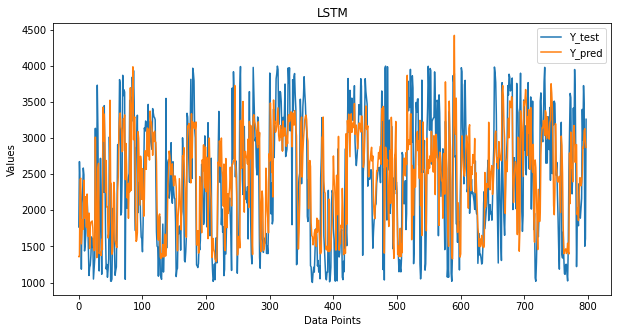

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(10,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

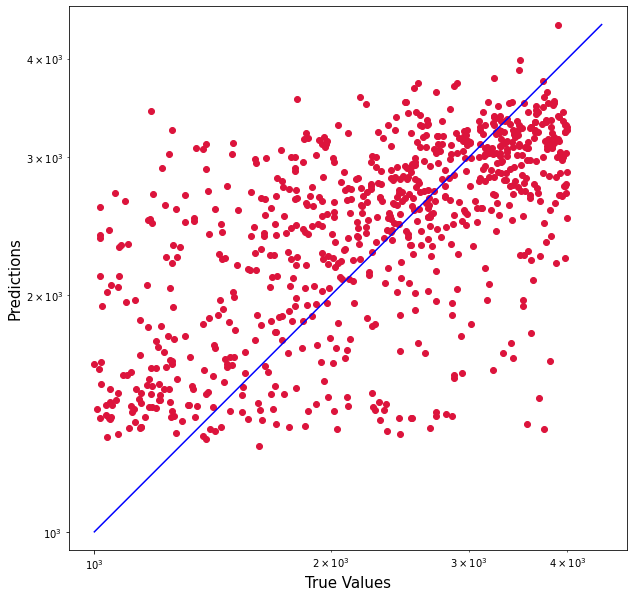

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(Y_test['DL_bitrate'], Y_pred[15], c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(Y_pred[15]), max(Y_test['DL_bitrate']))
p2 = min(min(Y_pred[15]), min(Y_test['DL_bitrate']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

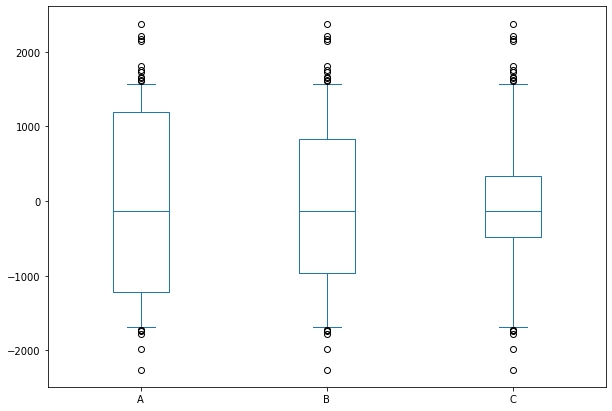

In [ ]:
import matplotlib.cbook as cbook
a=Y_test['DL_bitrate'].subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
Y_pred

,15
0,1359.141
1,1358.329
2,2423.795
3,2443.835
4,1534.941
...,...
793,2863.341
794,3100.066
795,3129.022
796,2946.065


In [ ]:
# calculate MAE
error = mae(Y_test, Y_pred)

# display
print("Mean absolute error : " + str(error))
print(f"Decimal Representation: {error:.20f}")

Mean absolute error : tf.Tensor(542.5138467639161, shape=(), dtype=float64)
Decimal Representation: 542.51384676391614902968


In [ ]:
# Mean Absolute Percentage Error
error = mean_absolute_percentage_error(Y_test, Y_pred)
print(error)

print(f" {error:.5f}")

0.26704432851099646
 0.26704


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

0.9753392690781034

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

1.141827270936615

## High Throughput

In [ ]:
frame_high_train = frame_high.sample(frac = 0.7, random_state=0)
frame_high_test = frame_high.drop(frame_high_train.index)

In [ ]:
frame_high_train.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
3642,8.361,8.073,8.017,8.036,8.177,2997.000,3288.000,3455.000,4194.000,7045.000,...,6.631,6.448,6.300,6.328,55.000,63.000,64.000,100.000,163.000,5531.000
8706,7.000,7.000,7.000,7.000,2.000,11027.000,11530.000,6833.000,13700.000,13499.000,...,1.000,-1.000,-1.000,-1.000,204.000,210.000,126.000,248.000,345.000,17403.000
4605,8.435,8.146,8.021,7.996,8.107,2483.000,3780.000,3399.000,3019.000,3534.000,...,6.707,6.319,6.264,6.347,45.000,70.000,62.000,67.000,65.000,4916.000
7717,8.000,8.000,6.000,5.000,2.000,14964.000,12962.000,10647.000,2382.000,1778.000,...,-6.000,-6.000,-8.000,-8.000,272.000,238.000,341.000,136.000,101.000,19681.000
10224,8.000,9.000,9.000,6.000,8.000,17055.000,16831.000,15176.000,6072.000,13834.000,...,-7.000,-7.000,-2.000,-2.000,290.000,316.000,293.000,110.000,214.000,11274.000


In [ ]:
frame_high_test.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
247,9.000,9.000,9.000,6.000,6.000,1644.000,1308.000,1151.000,973.000,794.000,...,2.000,2.000,1.000,1.000,31.000,25.000,21.000,18.000,22.000,4515.000
254,8.000,8.000,8.000,8.000,8.000,7661.000,6654.000,5334.000,5334.000,6542.000,...,6.000,5.000,6.000,4.000,141.000,123.000,99.000,99.000,121.000,9810.000
286,8.000,8.000,8.000,6.000,6.000,8320.000,8130.000,6565.000,2225.000,0.000,...,-4.000,-4.000,-6.000,-6.000,171.000,151.000,121.000,70.000,0.000,8193.000
288,7.000,7.000,8.000,8.000,8.000,8074.000,7862.000,8320.000,8130.000,6565.000,...,-3.000,-3.000,-4.000,-4.000,173.000,143.000,171.000,151.000,121.000,9119.000
291,7.000,7.000,7.000,7.000,7.000,8466.000,8779.000,7784.000,8074.000,7862.000,...,-2.000,-3.000,-3.000,-3.000,157.000,163.000,141.000,173.000,143.000,10080.000


### With Scaling

#### MinMax Scaler

In [ ]:
df = frame_high_train[col_names_scaled]
min_max_scaler = MinMaxScaler()
# transform data
df_min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))

In [ ]:
X_train_min_max_scaler, X_valid_min_max_scaler, Y_train_min_max_scaler, Y_valid_min_max_scaler = train_test_split(df_min_max_scaled.iloc[:,:-1], df_min_max_scaled.iloc[:,-1:], test_size=0.3, random_state=0)
print('Train set shape', X_train_min_max_scaler.shape)
print('Validation set shape', X_valid_min_max_scaler.shape)
X_train_min_max_scaler.head()

Train set shape (3254, 15)
Validation set shape (1395, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
989,0.528,0.506,0.501,0.499,0.507,0.068,0.075,0.067,0.072,0.083,0.478,0.448,0.442,0.450,0.452
306,0.571,0.571,0.786,0.571,0.571,0.093,0.121,0.108,0.095,0.081,0.457,0.457,0.457,0.426,0.447
10,0.286,0.429,0.071,0.286,0.071,0.129,0.191,0.048,0.035,0.145,0.304,0.174,0.174,0.191,0.191
14,1.000,1.000,0.786,0.786,0.714,0.257,0.304,0.307,0.222,0.159,0.652,0.652,0.630,0.638,0.617
1632,0.500,0.357,0.357,0.214,0.071,0.127,0.078,0.009,0.029,0.032,0.174,0.174,0.261,0.277,0.404


In [ ]:
X_train_min_max_series = X_train_min_max_scaler.values.reshape((X_train_min_max_scaler.shape[0], X_train_min_max_scaler.shape[1], 1))
X_valid_min_max_series = X_valid_min_max_scaler.values.reshape((X_valid_min_max_scaler.shape[0], X_valid_min_max_scaler.shape[1], 1))
print('Train set shape', X_train_min_max_series.shape)
print('Validation set shape', X_valid_min_max_series.shape)

Train set shape (3254, 15, 1)
Validation set shape (1395, 15, 1)


### Hyper Parameter Tuning using Keras Auto Tuner

In [ ]:
mae = MeanAbsoluteError()
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(X_train_min_max_series.shape[1], X_train_min_max_series.shape[2])))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512

  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  model.add(Dense(units=hp_units1, activation='relu'))
  model.add(Dropout(rate=hp.Float('dropout_1',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(tf.keras.layers.Dense(units=hp_units2, activation='relu'))
  model.add(Dropout(rate=hp.Float('dropout_2',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(tf.keras.layers.Dense(units=hp_units3, activation='relu'))

  model.add(Dropout(rate=hp.Float('dropout_3',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(Dense(1, kernel_initializer='normal', activation='linear'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),loss=mae,metrics=[mae])

  return model


In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_mean_absolute_error',
                     max_epochs=100,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt2')


In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, 
        verbose=1, mode='auto', restore_best_weights=True)

In [ ]:
tuner.search(X_train_min_max_series, Y_train_min_max_scaler, validation_data=(X_valid_min_max_series, Y_valid_min_max_scaler), epochs=100, callbacks=[monitor])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 254 Complete [00h 00m 25s]
val_mean_absolute_error: 0.0575963631272316

Best val_mean_absolute_error So Far: 0.05590088665485382
Total elapsed time: 00h 18m 22s


In [ ]:
for h_param in [f"units{i}" for i in range(1,4)] + ['learning_rate']:
  print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))

units1 416
units2 416
units3 160
learning_rate 0.0001


In [ ]:
best_model = tuner.get_best_models()[0]
best_model.build(X_train_min_max_series.shape)
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 15)                0         
                                                                 
 dense (Dense)               (None, 416)               6656      
                                                                 
 dropout (Dropout)           (None, 416)               0         
                                                                 
 dense_1 (Dense)             (None, 416)               173472    
                                                                 
 dropout_1 (Dropout)         (None, 416)               0         
                                                                 
 dense_2 (Dense)             (None, 160)               66720     
                                                                 
 dropout_2 (Dropout)         (None, 160)               0

In [ ]:
from keras.models import load_model

best_model.save('best_model.h5')  # creates a HDF5 file 'my_model.h5'
#model = load_model('my_model.h5')

In [ ]:
kt_train_pred_min_max_scaled = best_model.predict(X_train_min_max_scaler)
kt_valid_pred_min_max_scaled = best_model.predict(X_valid_min_max_scaler)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_min_max_scaler, kt_train_pred_min_max_scaled)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_min_max_scaler, kt_valid_pred_min_max_scaled)))

44/44 [==============================] - 0s 1ms/step
Train rmse: 0.07729698624231497
Validation rmse: 0.08850200514203309


In [ ]:
df = frame_high_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.571,0.571,0.538,0.357,0.357,0.019,0.015,0.013,0.011,0.009,0.364,0.370,0.362,0.340,0.326
1,0.500,0.500,0.462,0.500,0.500,0.088,0.076,0.061,0.061,0.075,0.386,0.457,0.426,0.447,0.391
2,0.500,0.500,0.462,0.357,0.357,0.096,0.093,0.075,0.025,0.000,0.205,0.239,0.234,0.191,0.174
3,0.429,0.429,0.462,0.500,0.500,0.093,0.089,0.095,0.093,0.075,0.205,0.261,0.255,0.234,0.217
4,0.429,0.429,0.385,0.429,0.429,0.097,0.100,0.089,0.092,0.090,0.227,0.283,0.255,0.255,0.239


In [ ]:
Y_test = frame_high_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = best_model.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

63/63 [==============================] - 0s 1ms/step


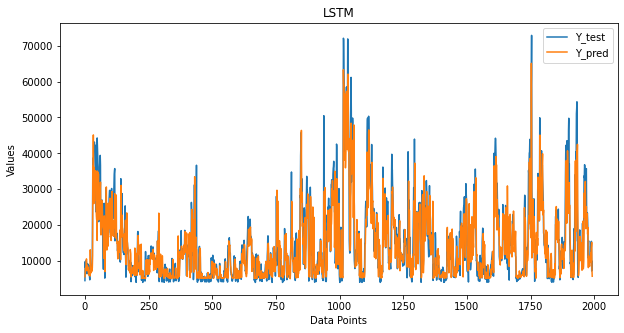

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(10,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

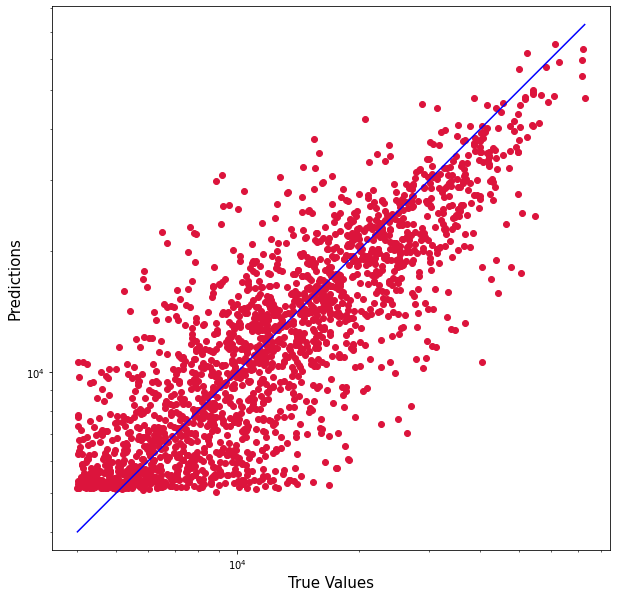

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(Y_test['DL_bitrate'], Y_pred[15], c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(Y_pred[15]), max(Y_test['DL_bitrate']))
p2 = min(min(Y_pred[15]), min(Y_test['DL_bitrate']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

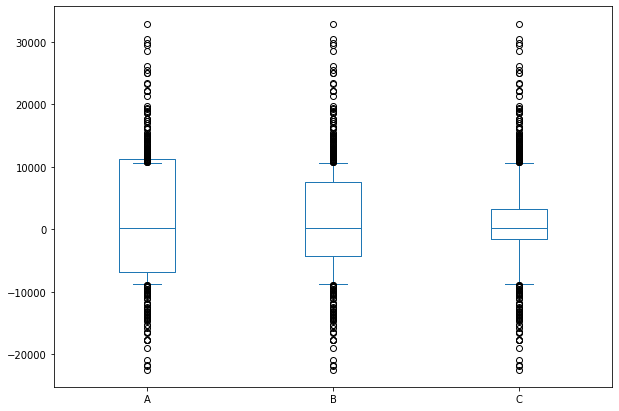

In [ ]:
import matplotlib.cbook as cbook
a=Y_test['DL_bitrate'].subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
Y_pred

,15
0,5598.489
1,6385.141
2,7957.799
3,7712.538
4,8467.522
...,...
1988,13470.088
1989,14500.550
1990,15190.518
1991,7527.602


In [ ]:
# calculate MAE
error = mae(Y_test, Y_pred)

# display
print("Mean absolute error : " + str(error))
print(f"Decimal Representation: {error:.20f}")

Mean absolute error : tf.Tensor(3765.748272115803, shape=(), dtype=float64)
Decimal Representation: 3765.74827211580304719973


In [ ]:
# Mean Absolute Percentage Error
error = mean_absolute_percentage_error(Y_test, Y_pred)
print(error)

print(f" {error:.5f}")

0.27106899357383757
 0.27107


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

0.5204861672891037

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

0.38190801111618006

# Without Throughput Split

In [ ]:
frame.shape

(10639, 46)

In [ ]:
frame_train = frame.sample(frac = 0.7, random_state=0)
frame_test = frame.drop(frame_train.index)

In [ ]:
frame_train.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
3472,8.657,8.185,8.045,7.921,7.964,6565.000,6185.000,5679.000,4742.000,1800.000,...,6.621,6.094,5.949,6.051,139.000,149.000,133.000,84.000,33.000,4799.000
3291,5.000,2.000,2.000,6.000,6.000,9305.000,5457.000,3601.000,7325.000,5972.000,...,-8.000,-8.000,1.000,1.000,177.000,86.000,63.000,174.000,111.000,2896.000
10505,7.000,7.000,7.000,7.000,7.000,21506.000,15635.000,17234.000,25879.000,23821.000,...,4.000,4.000,2.000,2.000,429.000,303.000,328.000,511.000,501.000,19743.000
8726,8.000,8.000,8.000,8.000,8.000,6039.000,7101.000,25880.000,18243.000,8991.000,...,5.000,4.000,4.000,4.000,112.000,133.000,465.000,332.000,227.000,9575.000
4374,8.434,8.138,8.109,7.997,8.072,649.000,503.000,2303.000,1241.000,682.000,...,6.724,6.313,5.982,6.078,15.000,17.000,42.000,23.000,16.000,825.000


In [ ]:
frame_test.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
0,7.000,7.000,10.000,7.000,7.000,0.000,0.000,310.000,3.000,3.000,...,7.000,7.000,10.000,10.000,0.000,0.000,14.000,7.000,7.000,1769.000
2,7.000,7.000,7.000,7.000,10.000,0.000,0.000,0.000,0.000,310.000,...,8.000,8.000,7.000,7.000,0.000,0.000,0.000,0.000,14.000,2549.000
3,9.000,7.000,7.000,7.000,7.000,1757.000,0.000,0.000,0.000,0.000,...,10.000,8.000,8.000,7.000,68.000,0.000,0.000,0.000,0.000,2674.000
5,9.000,9.000,9.000,7.000,7.000,2874.000,4216.000,1757.000,0.000,0.000,...,10.000,10.000,10.000,8.000,53.000,151.000,68.000,0.000,0.000,2151.000
10,7.000,9.000,7.000,7.000,8.000,1666.000,2807.000,2382.000,1386.000,2516.000,...,9.000,9.000,12.000,10.000,60.000,52.000,45.000,26.000,47.000,2462.000


## MinMax Scaler

In [ ]:
df = frame_train[col_names_scaled]
min_max_scaler = MinMaxScaler()
# transform data
df_min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))

In [ ]:
X_train_min_max_scaler, X_valid_min_max_scaler, Y_train_min_max_scaler, Y_valid_min_max_scaler = train_test_split(df_min_max_scaled.iloc[:,:15], df_min_max_scaled.iloc[:,-1:], test_size=0.3, random_state=0)
print('Train set shape', X_train_min_max_scaler.shape)
print('Validation set shape', X_valid_min_max_scaler.shape)
X_train_min_max_scaler.head()

Train set shape (5212, 15)
Validation set shape (2235, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
2014,0.500,0.429,0.429,0.286,0.357,0.000,0.000,0.000,0.003,0.003,0.319,0.319,0.383,0.383,0.340
3568,0.571,0.500,0.500,0.500,0.500,0.391,0.187,0.294,0.316,0.248,0.426,0.426,0.426,0.426,0.426
2551,0.643,0.714,0.643,0.714,0.714,0.138,0.144,0.135,0.182,0.137,0.702,0.681,0.681,0.723,0.723
7071,0.714,0.714,0.714,0.429,0.429,0.023,0.010,0.014,0.014,0.005,0.532,0.468,0.468,0.511,0.511
575,0.540,0.508,0.497,0.495,0.507,0.087,0.081,0.058,0.045,0.057,0.493,0.458,0.451,0.449,0.452


In [ ]:
X_train_min_max_series = X_train_min_max_scaler.values.reshape((X_train_min_max_scaler.shape[0], X_train_min_max_scaler.shape[1], 1))
X_valid_min_max_series = X_valid_min_max_scaler.values.reshape((X_valid_min_max_scaler.shape[0], X_valid_min_max_scaler.shape[1], 1))
print('Train set shape', X_train_min_max_series.shape)
print('Validation set shape', X_valid_min_max_series.shape)

Train set shape (5212, 15, 1)
Validation set shape (2235, 15, 1)


### Hyper Parameter Tuning using Keras Auto Tuner

In [ ]:
mae = MeanAbsoluteError()
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(X_train_min_max_series.shape[1], X_train_min_max_series.shape[2])))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512

  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  model.add(Dense(units=hp_units1, activation='relu'))
  model.add(Dropout(rate=hp.Float('dropout_1',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(tf.keras.layers.Dense(units=hp_units2, activation='relu'))
  model.add(Dropout(rate=hp.Float('dropout_2',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(tf.keras.layers.Dense(units=hp_units3, activation='relu'))

  model.add(Dropout(rate=hp.Float('dropout_3',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(Dense(1, kernel_initializer='normal', activation='linear'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),loss=mae,metrics=[mae])

  return model


In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_mean_absolute_error',
                     max_epochs=100,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt3')


In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, 
        verbose=1, mode='auto', restore_best_weights=True)

In [ ]:
tuner.search(X_train_min_max_series, Y_train_min_max_scaler, validation_data=(X_valid_min_max_series, Y_valid_min_max_scaler), epochs=100, callbacks=[monitor])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 254 Complete [00h 00m 30s]
val_mean_absolute_error: 0.03751614689826965

Best val_mean_absolute_error So Far: 0.03727153688669205
Total elapsed time: 00h 25m 36s


In [ ]:
for h_param in [f"units{i}" for i in range(1,4)] + ['learning_rate']:
  print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))

units1 352
units2 352
units3 32
learning_rate 0.001


In [ ]:
best_model = tuner.get_best_models()[0]
best_model.build(X_train_min_max_series.shape)
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 15)                0         
                                                                 
 dense (Dense)               (None, 352)               5632      
                                                                 
 dropout (Dropout)           (None, 352)               0         
                                                                 
 dense_1 (Dense)             (None, 352)               124256    
                                                                 
 dropout_1 (Dropout)         (None, 352)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                11296     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0

In [ ]:
from keras.models import load_model

best_model.save('best_model.h5')  # creates a HDF5 file 'my_model.h5'
#model = load_model('my_model.h5')

In [ ]:
kt_train_pred_min_max_scaled = best_model.predict(X_train_min_max_scaler)
kt_valid_pred_min_max_scaled = best_model.predict(X_valid_min_max_scaler)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_min_max_scaler, kt_train_pred_min_max_scaled)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_min_max_scaler, kt_valid_pred_min_max_scaled)))

70/70 [==============================] - 0s 1ms/step
Train rmse: 0.06168028455862919
Validation rmse: 0.06362580442905567


In [ ]:
df = frame_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.429,0.429,0.643,0.429,0.429,0.000,0.000,0.004,0.000,0.000,0.489,0.468,0.468,0.532,0.532
1,0.429,0.429,0.429,0.429,0.643,0.000,0.000,0.000,0.000,0.004,0.532,0.489,0.489,0.468,0.468
2,0.571,0.429,0.429,0.429,0.429,0.022,0.000,0.000,0.000,0.000,0.532,0.532,0.489,0.489,0.468
3,0.571,0.571,0.571,0.429,0.429,0.036,0.048,0.021,0.000,0.000,0.532,0.532,0.532,0.532,0.489
4,0.429,0.571,0.429,0.429,0.500,0.021,0.032,0.028,0.016,0.032,0.489,0.511,0.511,0.574,0.532


In [ ]:
Y_test = frame_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = best_model.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

100/100 [==============================] - 0s 1ms/step


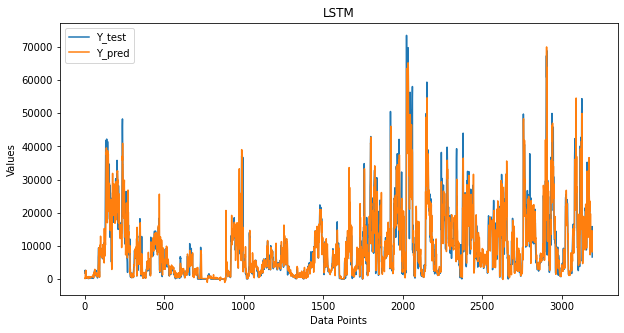

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(10,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

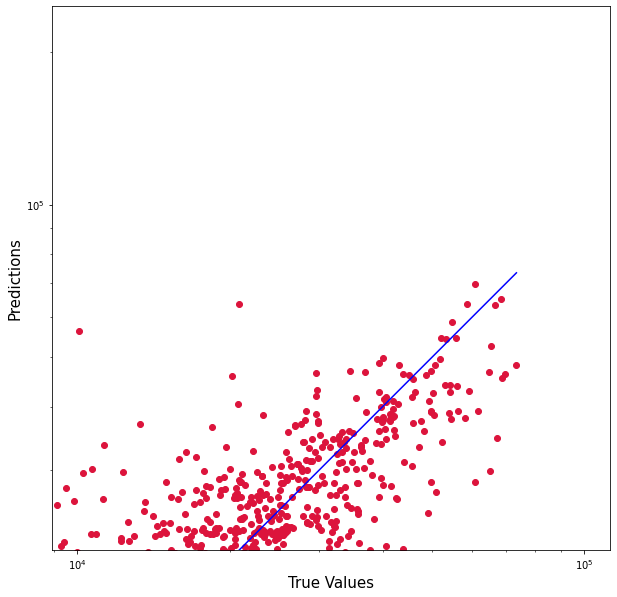

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(Y_test['DL_bitrate'], Y_pred[15], c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(Y_pred[15]), max(Y_test['DL_bitrate']))
p2 = min(min(Y_pred[15]), min(Y_test['DL_bitrate']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

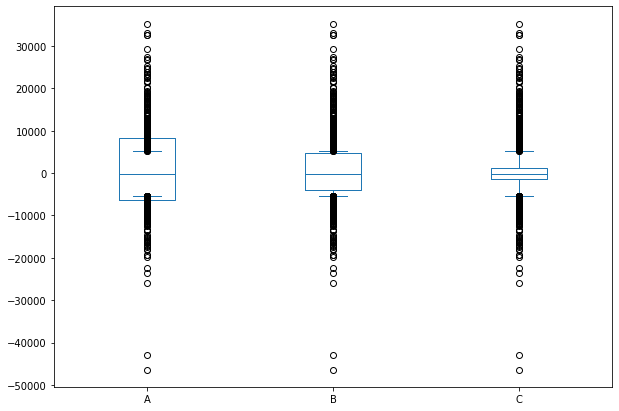

In [ ]:
import matplotlib.cbook as cbook
a=Y_test['DL_bitrate'].subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
# calculate MAE
error = mae(Y_test, Y_pred)

# display
print("Mean absolute error : " + str(error))
print(f"Decimal Representation: {error:.20f}")

Mean absolute error : tf.Tensor(2787.1419455631376, shape=(), dtype=float64)
Decimal Representation: 2787.14194556313759676414


In [ ]:
# Mean Absolute Percentage Error
error = mean_absolute_percentage_error(Y_test, Y_pred)
print(error)

print(f" {error:.5f}")

7.783148431634669e+16
 77831484316346688.00000


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

0.37209807508232334

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

0.24840045830000118

## Testing on SPlit Throughput

## Low Throughput

In [ ]:
df = frame_low_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.727,0.889,0.800,0.583,0.615,0.032,0.132,0.013,0.188,0.134,0.750,0.833,0.826,0.885,0.796
1,0.636,0.556,0.600,0.583,0.615,0.122,0.084,0.008,0.027,0.096,0.542,0.542,0.739,0.769,0.761
2,0.455,0.556,0.600,0.417,0.538,0.077,0.119,0.019,0.012,0.103,0.458,0.458,0.522,0.615,0.519
3,0.455,0.556,0.500,0.333,0.462,0.098,0.001,0.062,0.086,0.020,0.500,0.500,0.435,0.500,0.519
4,0.545,0.667,0.600,0.417,0.462,0.013,0.052,0.054,0.038,0.060,0.458,0.458,0.391,0.462,0.450


In [ ]:
Y_test = frame_low_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = best_model.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

13/13 [==============================] - 0s 1ms/step


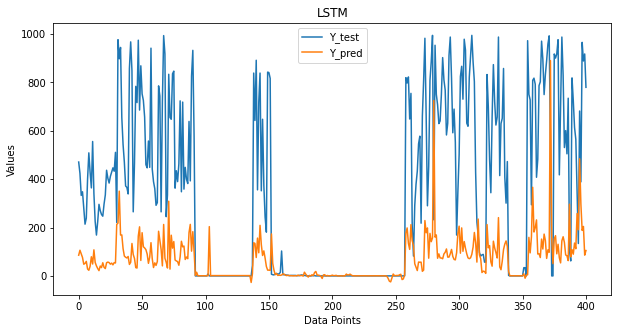

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(10,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

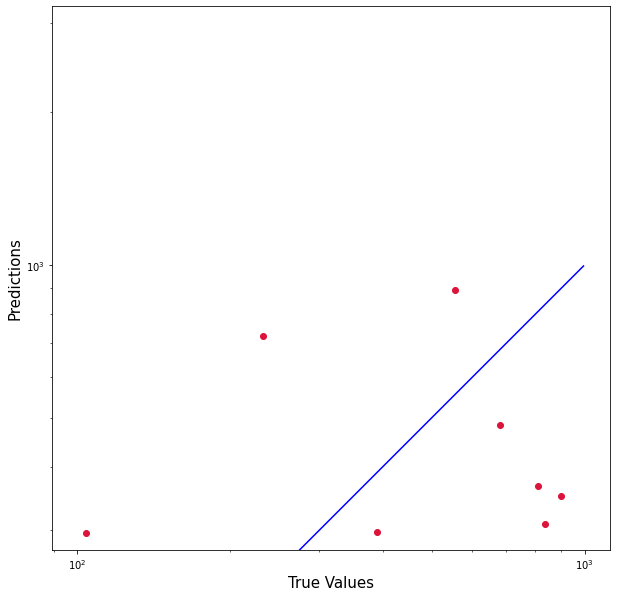

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(Y_test['DL_bitrate'], Y_pred[15], c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(Y_pred[15]), max(Y_test['DL_bitrate']))
p2 = min(min(Y_pred[15]), min(Y_test['DL_bitrate']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

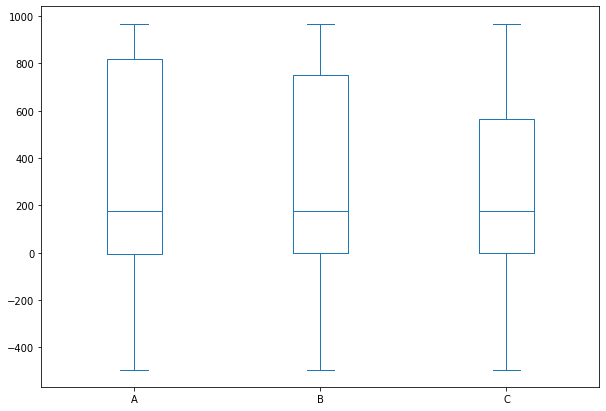

In [ ]:
import matplotlib.cbook as cbook
a=Y_test['DL_bitrate'].subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
Y_pred

,15
0,85.606
1,106.115
2,90.556
3,76.394
4,48.335
...,...
396,297.302
397,188.260
398,204.518
399,85.833


In [ ]:
# calculate MAE
error = mae(Y_test, Y_pred)

# display
print("Mean absolute error : " + str(error))
print(f"Decimal Representation: {error:.20f}")

Mean absolute error : tf.Tensor(284.92768846051837, shape=(), dtype=float64)
Decimal Representation: 284.92768846051836817423


In [ ]:
# Mean Absolute Percentage Error
error = mean_absolute_percentage_error(Y_test, Y_pred)
print(error)

print(f" {error:.5f}")

8292099407965155.0
 8292099407965155.00000


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

1.017632597662279

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

2.041419234233241

## Medium Throughput

In [ ]:
df = frame_medium_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.429,0.429,0.615,0.385,0.429,0.000,0.000,0.014,0.000,0.000,0.605,0.595,0.595,0.641,0.641
1,0.571,0.429,0.385,0.385,0.429,0.084,0.000,0.000,0.000,0.000,0.658,0.676,0.622,0.590,0.564
2,0.429,0.500,0.538,0.538,0.571,0.067,0.121,0.134,0.217,0.062,0.711,0.676,0.676,0.641,0.641
3,0.429,0.429,0.385,0.538,0.429,0.184,0.053,0.078,0.145,0.084,0.605,0.622,0.622,0.615,0.615
4,0.357,0.357,0.308,0.308,0.071,0.064,0.076,0.043,0.005,0.000,0.184,0.162,0.162,0.128,0.128


In [ ]:
Y_test = frame_medium_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = best_model.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

25/25 [==============================] - 0s 1ms/step


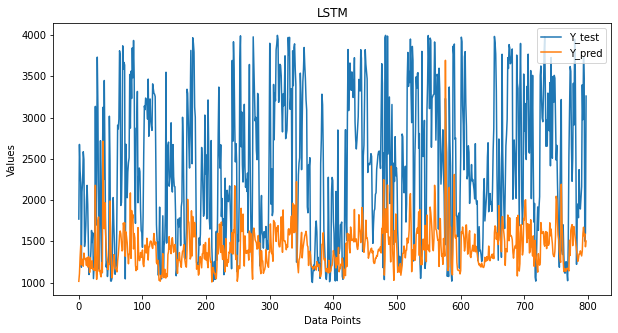

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(10,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

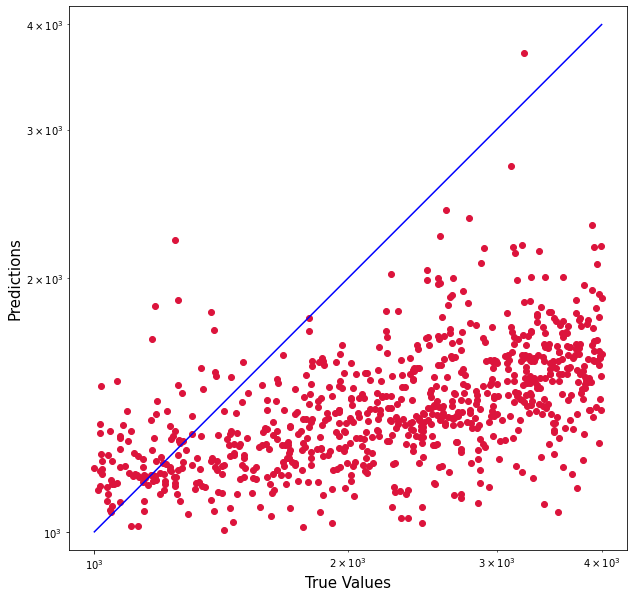

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(Y_test['DL_bitrate'], Y_pred[15], c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(Y_pred[15]), max(Y_test['DL_bitrate']))
p2 = min(min(Y_pred[15]), min(Y_test['DL_bitrate']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

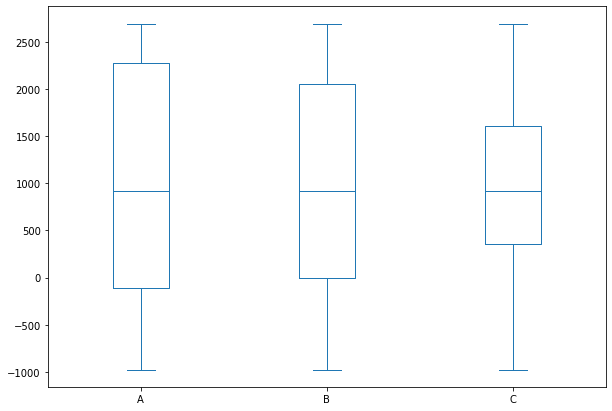

In [ ]:
import matplotlib.cbook as cbook
a=Y_test['DL_bitrate'].subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
Y_pred

,15
0,1014.670
1,1106.951
2,1303.524
3,1448.611
4,1214.472
...,...
793,1669.892
794,1562.816
795,1590.619
796,1433.535


In [ ]:
# calculate MAE
error = mae(Y_test, Y_pred)

# display
print("Mean absolute error : " + str(error))
print(f"Decimal Representation: {error:.20f}")

Mean absolute error : tf.Tensor(1019.6456335199201, shape=(), dtype=float64)
Decimal Representation: 1019.64563351992012485425


In [ ]:
# Mean Absolute Percentage Error
error = mean_absolute_percentage_error(Y_test, Y_pred)
print(error)

print(f" {error:.5f}")

0.36783513202747037
 0.36784


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

1.0298652110830755

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

1.4965165860773009

## High Throughput

In [ ]:
df = frame_high_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.571,0.571,0.538,0.357,0.357,0.019,0.015,0.013,0.011,0.009,0.364,0.370,0.362,0.340,0.326
1,0.500,0.500,0.462,0.500,0.500,0.088,0.076,0.061,0.061,0.075,0.386,0.457,0.426,0.447,0.391
2,0.500,0.500,0.462,0.357,0.357,0.096,0.093,0.075,0.025,0.000,0.205,0.239,0.234,0.191,0.174
3,0.429,0.429,0.462,0.500,0.500,0.093,0.089,0.095,0.093,0.075,0.205,0.261,0.255,0.234,0.217
4,0.429,0.429,0.385,0.429,0.429,0.097,0.100,0.089,0.092,0.090,0.227,0.283,0.255,0.255,0.239


In [ ]:
Y_test = frame_high_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = best_model.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

63/63 [==============================] - 0s 1ms/step


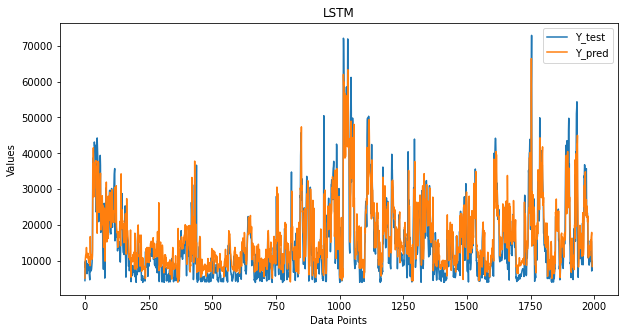

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(10,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

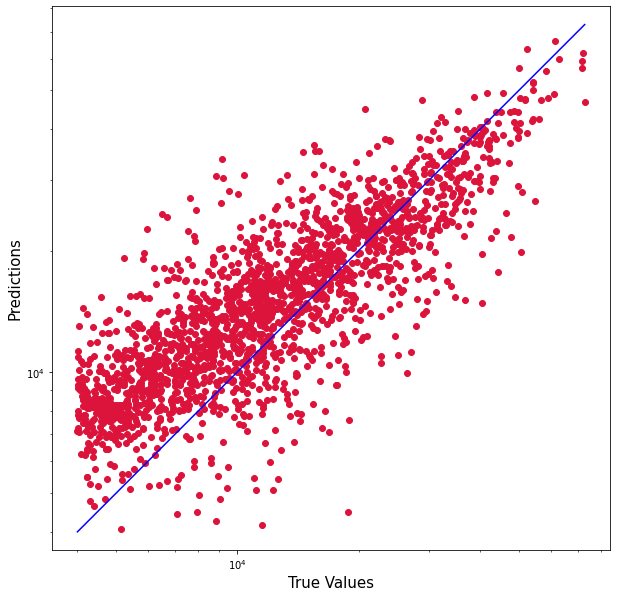

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(Y_test['DL_bitrate'], Y_pred[15], c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(Y_pred[15]), max(Y_test['DL_bitrate']))
p2 = min(min(Y_pred[15]), min(Y_test['DL_bitrate']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

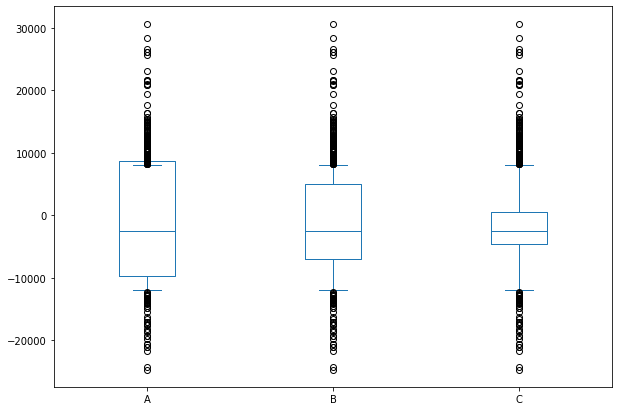

In [ ]:
import matplotlib.cbook as cbook
a=Y_test['DL_bitrate'].subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
Y_pred

,15
0,5218.891
1,10105.690
2,10939.683
3,11669.374
4,11931.506
...,...
1988,16576.464
1989,17324.261
1990,17954.775
1991,10828.985


In [ ]:
# calculate MAE
error = mae(Y_test, Y_pred)

# display
print("Mean absolute error : " + str(error))
print(f"Decimal Representation: {error:.20f}")

Mean absolute error : tf.Tensor(4447.918905040204, shape=(), dtype=float64)
Decimal Representation: 4447.91890504020375374239


In [ ]:
# Mean Absolute Percentage Error
error = mean_absolute_percentage_error(Y_test, Y_pred)
print(error)

print(f" {error:.5f}")

0.41838175602904343
 0.41838


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

0.6782051488119705

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

0.42019993506405323